In [1]:
#imports
import string # from some string manipulation tasks
import nltk # natural language toolkit
import re # regex
from string import punctuation # solving punctuation problems
from nltk.corpus import stopwords # stop words in sentences
from nltk.stem import WordNetLemmatizer # For stemming the sentence
from nltk.stem import SnowballStemmer # For stemming the sentence
from contractions import contractions_dict # to solve contractions
from autocorrect import Speller #correcting the spellings

# Sentiment we'll use
1. Negative
2. Somewhat Negative
3. Neutral
4. Somewhat positive
5. Positive

# Analysis of data for basic understanding

In [2]:
import numpy as np
import pandas as pd

In [3]:
# load the data
train_data = pd.read_csv("train.tsv", delimiter="\t", index_col="PhraseId")

In [4]:
train_data.head()

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2
4,1,A,2
5,1,series,2


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156060 entries, 1 to 156060
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SentenceId  156060 non-null  int64 
 1   Phrase      156060 non-null  object
 2   Sentiment   156060 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# see the sentiment distribution
train_data["Sentiment"].value_counts()

Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64

### Visualization

In [7]:
# ! pip install matplotlib seaborn

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

In [9]:
# introduce length column to represent length of each phrase in each row
train_data["Length"] = train_data["Phrase"].apply(len) # doing len() won't work here

In [10]:
len(train_data)

156060

<Axes: ylabel='Frequency'>

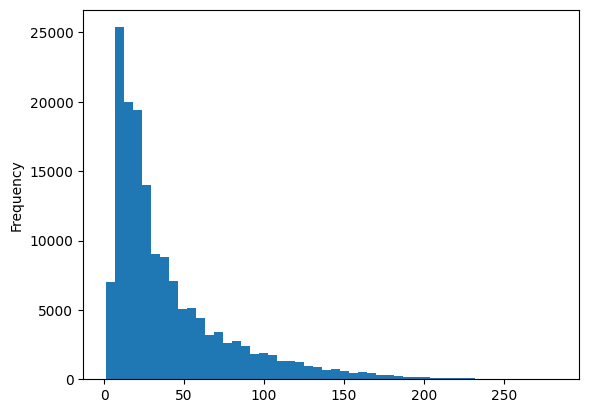

In [11]:
# Histogram
# based on the bins, we'll see in y which length is actually higher, thus the frequency
train_data["Length"].plot(kind="hist", bins=50)

array([[<Axes: title={'center': 'Length'}>]], dtype=object)

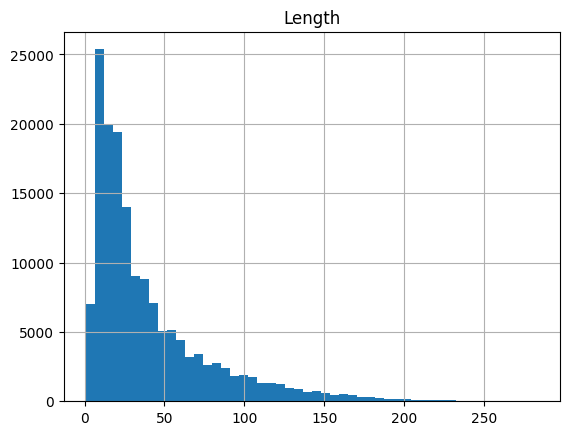

In [12]:

train_data.hist(column="Length", bins=50)

Text(0.5, 0.98, 'Lenth via each Sentiment')

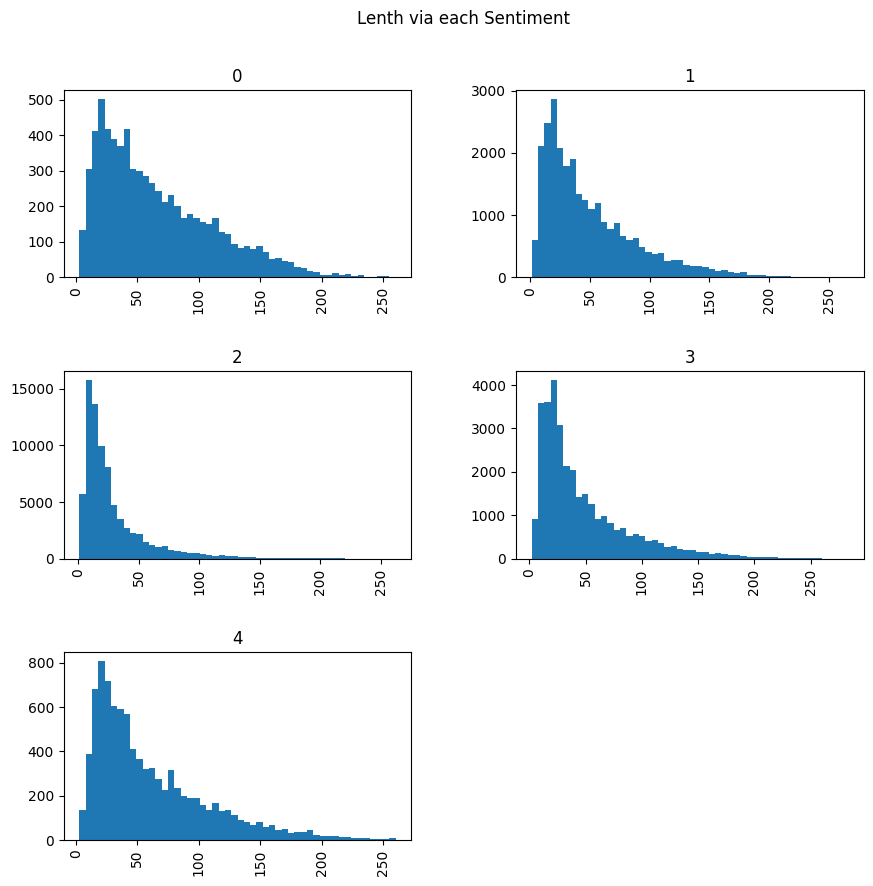

In [13]:
# length of phrase via each sentiment
ax = train_data.hist(column="Length", by="Sentiment", bins=50, figsize=(10, 10))
pl.suptitle("Lenth via each Sentiment")

> **Graph conclusion:** We can see that there are a lot of negative, and positive reviews that have lengths > 100 (the x-axis value). This means that when a customer is happy, or sad, they tend to write longer reviews compared to someone neutral

# Pipeline
- we'll need a pipeline because any textual data used to test the model needs to be processed in the same way that the model is preprocessed, and calling these functions explicitly will be difficult. So, we'll combine each of the steps using the pipeline to simplify the task

## 1. Tokenziation

In [14]:
# split the sentence into a list of sentences
# Type 1 Tokenization
def sentence_tokenize(text):
    """
    Take string input and return a list of sentence
    use nltk.sent_tokenize() to split the sentences.
    """
    return nltk.sent_tokenize(text)

In [15]:
# split the strings into a list of words
# Type II Tokenize
def word_tokenize(text):
    """
    :param text:
    :return: list of words
    """
    return nltk.word_tokenize(text)

In [16]:
# nltk.download() # to download the nltk related data

In [17]:
# specify the nltk data path
nltk.data.path.append("/Sentiment Analysis/nltk_data")

In [18]:
train_data["Phrase"].apply(sentence_tokenize)

PhraseId
1         [A series of escapades demonstrating the adage...
2         [A series of escapades demonstrating the adage...
3                                                [A series]
4                                                       [A]
5                                                  [series]
                                ...                        
156056                                          [Hearst 's]
156057                          [forced avuncular chortles]
156058                                 [avuncular chortles]
156059                                          [avuncular]
156060                                           [chortles]
Name: Phrase, Length: 156060, dtype: object

In [19]:
train_data["Phrase"].apply(word_tokenize)

PhraseId
1         [A, series, of, escapades, demonstrating, the,...
2         [A, series, of, escapades, demonstrating, the,...
3                                               [A, series]
4                                                       [A]
5                                                  [series]
                                ...                        
156056                                         [Hearst, 's]
156057                        [forced, avuncular, chortles]
156058                                [avuncular, chortles]
156059                                          [avuncular]
156060                                           [chortles]
Name: Phrase, Length: 156060, dtype: object

## 2. Upper to Lower Case

In [20]:
def to_lower(text):
    """
    :param text:
    :return:
        Converted text to lower case
        Eg: HELLO -> hello, Hello -> hello
    """
    return text.lower()

In [21]:
train_data["Phrase"].apply(to_lower)

PhraseId
1         a series of escapades demonstrating the adage ...
2         a series of escapades demonstrating the adage ...
3                                                  a series
4                                                         a
5                                                    series
                                ...                        
156056                                            hearst 's
156057                            forced avuncular chortles
156058                                   avuncular chortles
156059                                            avuncular
156060                                             chortles
Name: Phrase, Length: 156060, dtype: object

## 3. Check and Correct Misspells

In [33]:
# skip if slow pc, as it might take even hours
def autospell(text):
    """
    Correct the spelling of the word.
    """
    spell = Speller()
    spells = [spell(w) for w in (nltk.word_tokenize(text))]
    return " ".join(spells)

In [24]:
# correct the spelling for first 200 rows
train_data['Phrase'][:200].apply(autospell) 

PhraseId
1      A series of escapes demonstrating the adage th...
2      A series of escapes demonstrating the adage th...
3                                               A series
4                                                      A
5                                                 series
                             ...                        
196                                       midwife crisis
197                                              midwife
198                                               crisis
199    Narrative , Trouble Every Day is a padding mess .
200                                            Narrative
Name: Phrase, Length: 200, dtype: object

## 4. Remove Punctuations

In [26]:
def remove_punct(text):
    return "".join(c for c in text if c not in punctuation)

## 5. Remove numbers

In [27]:
# in our dataset numbers don't have any meaning
def remove_numbers(text):
    """
    take string input and return a clean text without numbers.
    Use regex to discard the numbers.
    """
    output = "".join(c for c in text if not c.isdigit())
    return output

In [28]:
z = pd.Series(["a1", "b2e", "a3"])
z.apply(remove_numbers)

0     a
1    be
2     a
dtype: object

## 6. Remove the stopwords 

In [29]:
def remove_stopwords(sentence):
    """
    removes all the stop words like "is, the, a, etc."
    """
    stop_words = stopwords.words("english")
    return " ".join([w for w in nltk.word_tokenize(sentence) if not w in stop_words ])

In [30]:
print(train_data["Phrase"][9:11])
train_data["Phrase"][9:11].apply(remove_stopwords)

PhraseId
10    demonstrating the adage that what is good for ...
11                              demonstrating the adage
Name: Phrase, dtype: object


PhraseId
10    demonstrating adage good goose
11               demonstrating adage
Name: Phrase, dtype: object

## 7. Normalization

In [31]:
# since lemmatization return lemma or dictionary format and contain more meaning
# we'll use it instead of stemming
def lemmatize(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]
    return " ".join(lemmatized_word)

In [34]:
def preprocess(text):
    lower_text = to_lower(text)
    # lower_text = autospell(lower_text)
    sentence_tokens = sentence_tokenize(lower_text)
    word_list = []
    for each_sent in sentence_tokens:
        lemmatizzed_sent = lemmatize(each_sent)
        clean_text = remove_numbers(lemmatizzed_sent)
        clean_text = remove_punct(clean_text)
        clean_text = remove_stopwords(clean_text)
        word_tokens = word_tokenize(clean_text)
        for i in word_tokens:
            word_list.append(i)
    return word_list

In [35]:
sample_data = train_data["Phrase"].head(5)
print(sample_data)
sample_data.apply(preprocess)

PhraseId
1    A series of escapades demonstrating the adage ...
2    A series of escapades demonstrating the adage ...
3                                             A series
4                                                    A
5                                               series
Name: Phrase, dtype: object


PhraseId
1    [series, escapade, demonstrating, adage, good,...
2    [series, escapade, demonstrating, adage, good,...
3                                             [series]
4                                                   []
5                                             [series]
Name: Phrase, dtype: object

# Transform to a machine learning model understandable form